In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# 16S rRNA data obtained by my own from ticks gut.
data = pd.read_csv('./classified_species_BC_15.csv')

In [4]:
def describe_dataframe(dataframe):
    """The introduction function to explore the dataframe"""
    print(dataframe.shape)
    print(dataframe.head())
    print(dataframe.info())
    plt.rcParams["figure.figsize"] = (12, 8)
    plt.plot(dataframe['count'], lw=3, c='r')
    plt.xlabel('species ID')
    plt.ylabel('number of reads belonging to the species')
    plt.show()

In [5]:
def create_sql_table(dataframe, connect):
    """Save pandas.DataFrame dataframe file as a SQL-table and return sqlite3.cursor instance"""
    cursor = connect.cursor()
    dataframe.to_sql('metagenome', connect, if_exists='replace', index=False)
    return cursor

In [6]:
def filter_table(cursor, method='percent', percent=1, count=5000):
    """This function filters SQL-table
    - percent_filter – filters SQL-table  by species present percent
    - count_filter – filters SQL-table by number of reads belonging to species
    - method – {percent, count}, default - percent. Decide how to filter SQL-table. """

    def percent_filter(cur, per):
        subset = cur.execute(f"""SELECT * FROM metagenome WHERE percent > {per}""").fetchall()
        return pd.DataFrame(subset, columns=['species', 'count', 'percent'])

    def count_filter(cur, cnt):
        subset = cur.execute(f"""SELECT * FROM metagenome WHERE count > {cnt}""").fetchall()
        return pd.DataFrame(subset, columns=['species', 'count', 'percent'])

    if method == 'percent':
        return percent_filter(cursor, percent)
    elif method == 'count':
        return count_filter(cursor, count)
    else:
        raise ValueError('Available methods are: percent and count')

In [7]:
def count_reads(cursor):
    """This function count number of total defined reads in SQL-table"""
    return cursor.execute("""SELECT sum(count) FROM metagenome""").fetchone()[0]

In [8]:
def delete_row(cursor, species):
    """Delete row with specific species ID and recount percent column"""
    cursor.execute(f"""DELETE FROM metagenome WHERE species ='{species}'""")
    total_number = count_reads(cursor)
    cursor.execute(f"""UPDATE metagenome SET percent = CAST(count*100 AS float) / {total_number}""")
    return cursor

In [9]:
def main():
    # This is 16S sequencing data obtained by my own from tick gut
    conn = sqlite3.connect('metagenome.db')
    data = pd.read_csv('./classified_species_BC_15.csv')
    describe_dataframe(data)
    cur = create_sql_table(data, connect=conn)
    data_flt_count = filter_table(cur, method='count', count=1000)
    print(data_flt_count.tail())
    data_flt_percent = filter_table(cur, method='percent', percent=5)
    print(data_flt_percent.tail())
    reads = count_reads(cur)
    print(f"Total number of reads: {reads}")
    delete_row(cursor= cur, species='Methylobacterium goesingense')
    conn.commit()

(1346, 3)
                             species  count  percent
0       Methylobacterium goesingense  45861   10.699
1     Staphylococcus saccharolyticus  39657    9.252
2                 Sphingomonas faeni  34089    7.953
3  Escherichia fergusonii ATCC 35469  26741    6.239
4            Streptococcus sanguinis  25321    5.907
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1346 entries, 0 to 1345
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   species  1346 non-null   object 
 1   count    1346 non-null   int64  
 2   percent  1346 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 31.7+ KB
None


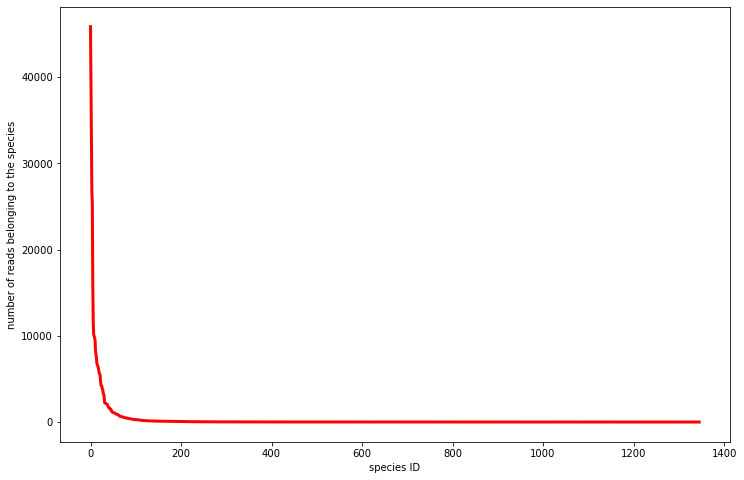

                                      species  count  percent
50                   Aurantimonas endophytica   1123    0.262
51                   Bradyrhizobium mercantei   1101    0.257
52  Staphylococcus capitis subsp. urealyticus   1080    0.252
53                     Methylorubrum zatmanii   1057    0.247
54             Anaerococcus urinomassiliensis   1002    0.234
                             species  count  percent
0       Methylobacterium goesingense  45861   10.699
1     Staphylococcus saccharolyticus  39657    9.252
2                 Sphingomonas faeni  34089    7.953
3  Escherichia fergusonii ATCC 35469  26741    6.239
4            Streptococcus sanguinis  25321    5.907
Total number of reads: 428630


In [10]:
if __name__ == '__main__':
    main()